In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# train_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')
test_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')
train_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_resampled.csv')

<ipython-input-3-2e186060b6d2>:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train_resampled.csv')


In [ ]:
train = train_original.copy()
test = test_original.copy()

In [ ]:
train.head()

,Unnamed: 0,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,19084848,15193,26,1,36,121,2017-11-07 02:55:33,NaN,0
1,8631823,192030,3,1,13,205,2017-11-06 23:45:34,NaN,0
2,43013023,114220,13,1,19,477,2017-11-07 10:36:55,NaN,0
3,67882362,27639,15,1,13,245,2017-11-07 23:35:47,NaN,0
4,19820611,19140,15,1,3,315,2017-11-07 03:09:26,NaN,0


In [ ]:
test.head()

,Unnamed: 0,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,114713810,196112,13,1,19,477,2017-11-08 13:54:15,NaN,0
1,21489917,131406,3,1,19,379,2017-11-07 03:40:47,NaN,0
2,181845208,32625,9,1,37,134,2017-11-09 14:59:23,NaN,0
3,62052135,234242,1,1,37,125,2017-11-07 17:00:46,NaN,0
4,67738375,109261,3,1,19,115,2017-11-07 23:32:17,NaN,0


In [ ]:
train.drop(labels='Unnamed: 0', axis=1, inplace=True)
test.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  int64 
 1   app              100000 non-null  int64 
 2   device           100000 non-null  int64 
 3   os               100000 non-null  int64 
 4   channel          100000 non-null  int64 
 5   click_time       100000 non-null  object
 6   attributed_time  25000 non-null   object
 7   is_attributed    100000 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.1+ MB


# Initial Preprocessing

### Missing Values

In [ ]:
train.isnull().sum(axis = 0)

ip                     0
app                    0
device                 0
os                     0
channel                0
click_time             0
attributed_time    75000
is_attributed          0
dtype: int64

### What happened to attributed_time?

In [ ]:
temp1 = train.loc[~train.attributed_time.isnull(),'is_attributed']
if np.sum(temp1.values) == len(temp1):
  print('Same')
else:
  print('No')
print('-'*50)
temp2 = train.loc[train.attributed_time.isnull(),'is_attributed']
if np.sum(temp2.values) == 0:
  print('Same')
else:
  print('No')

# whenever is_attributed == 1, then there is a corresponding time in attributed_time

Same
--------------------------------------------------
Same


### Label Distribution

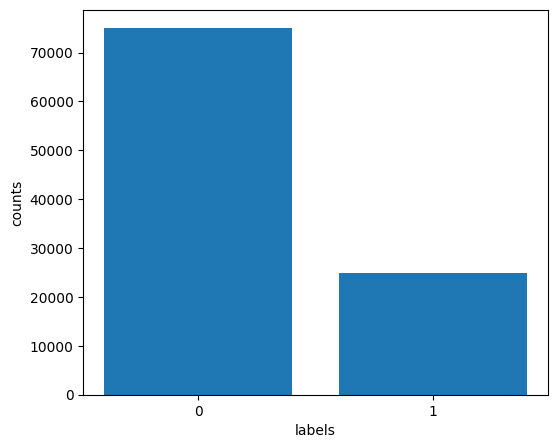

In [ ]:
fig = plt.figure(figsize=(6,5))
plt.bar(train.is_attributed.value_counts().index, train.is_attributed.value_counts().values)
plt.xlabel('labels')
plt.ylabel('counts')
plt.xticks([0,1])
plt.show()

### Feature Distribution



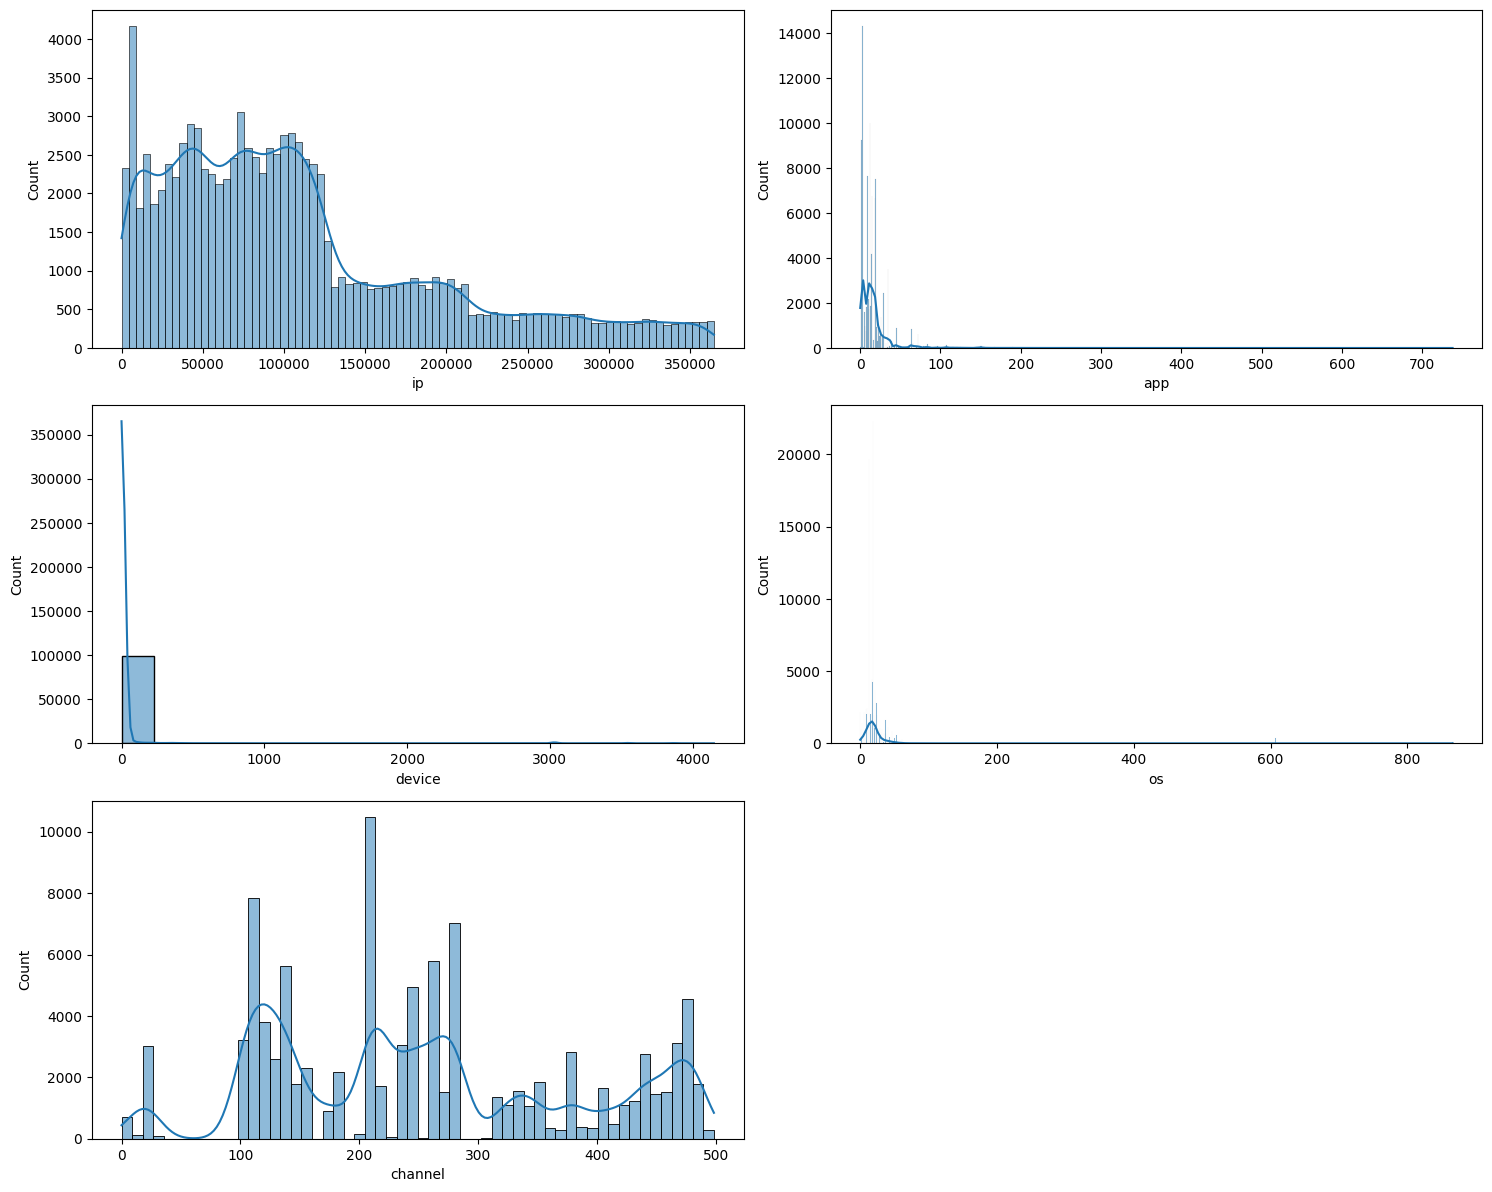

In [ ]:
fig = plt.figure(figsize=(15,12))
for i, col in enumerate(['ip','app','device','os','channel']):
  plt.subplot(3,2,i+1)
  sns.histplot(data=train, x=col, label = col, kde=True)
fig.tight_layout(pad=1.0)

### Click Time Transformation

In [ ]:
def transformation(df):
  df['click_time'] = pd.to_datetime(df.click_time)
  df['day_of_week'] = df.click_time.dt.day_of_week
  df['day'] = df.click_time.dt.day
  df['hour'] = df.click_time.dt.hour
  #df.drop(labels='click_time', axis=1, inplace = True)
  return df

# transformation
train = transformation(train)
test = transformation(test)

In [ ]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day_of_week,day,hour
0,15193,26,1,36,121,2017-11-07 02:55:33,NaN,0,1,7,2
1,192030,3,1,13,205,2017-11-06 23:45:34,NaN,0,0,6,23
2,114220,13,1,19,477,2017-11-07 10:36:55,NaN,0,1,7,10
3,27639,15,1,13,245,2017-11-07 23:35:47,NaN,0,1,7,23
4,19140,15,1,3,315,2017-11-07 03:09:26,NaN,0,1,7,3


In [ ]:
test.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,day_of_week,day,hour
0,196112,13,1,19,477,2017-11-08 13:54:15,NaN,0,2,8,13
1,131406,3,1,19,379,2017-11-07 03:40:47,NaN,0,1,7,3
2,32625,9,1,37,134,2017-11-09 14:59:23,NaN,0,3,9,14
3,234242,1,1,37,125,2017-11-07 17:00:46,NaN,0,1,7,17
4,109261,3,1,19,115,2017-11-07 23:32:17,NaN,0,1,7,23


### Deleting variables

In [ ]:
# store the label
train_labels = train.is_attributed.values
test_labels = test.is_attributed.values

# drop labels and attributed_time since it represnets the same info as the is_attributed
train.drop(labels = ['attributed_time', 'is_attributed'], axis = 1, inplace = True)
test.drop(labels = ['attributed_time', 'is_attributed'], axis = 1, inplace = True)

In [ ]:
train.head()

,ip,app,device,os,channel,click_time,day_of_week,day,hour
0,15193,26,1,36,121,2017-11-07 02:55:33,1,7,2
1,192030,3,1,13,205,2017-11-06 23:45:34,0,6,23
2,114220,13,1,19,477,2017-11-07 10:36:55,1,7,10
3,27639,15,1,13,245,2017-11-07 23:35:47,1,7,23
4,19140,15,1,3,315,2017-11-07 03:09:26,1,7,3


In [ ]:
test.head()

,ip,app,device,os,channel,click_time,day_of_week,day,hour
0,196112,13,1,19,477,2017-11-08 13:54:15,2,8,13
1,131406,3,1,19,379,2017-11-07 03:40:47,1,7,3
2,32625,9,1,37,134,2017-11-09 14:59:23,3,9,14
3,234242,1,1,37,125,2017-11-07 17:00:46,1,7,17
4,109261,3,1,19,115,2017-11-07 23:32:17,1,7,23


# Baseline Model - Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

temp_train = train.drop(labels='click_time', axis=1)
temp_test = test.drop(labels='click_time', axis=1)

# Initialize logistic regression model with 'sag' solver
model = LogisticRegression(solver='sag', C=1.0, max_iter=10000, penalty='l2')

# Train the model
model.fit(temp_train, train_labels)

# Predictions
y_pred = model.predict(temp_test)
y_pred_proba = model.predict_proba(temp_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(test_labels, y_pred)
auc_score = roc_auc_score(test_labels, y_pred_proba)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")


Accuracy: 92.63%
AUC Score: 0.7211591976669115


# Feature Engineering

### 统计特征

In [ ]:
from tqdm import tqdm

def transform_data(df):
    # Initialize list of column groups
    column_groups = [['ip'], ['ip', 'os', 'device'], ['ip', 'day', 'hour']]

    # Process each column group
    for cols in tqdm(column_groups, desc="Count"):
        name = '_'.join(cols)
        df[name + '_cnts'] = df.groupby(cols)['click_time'].transform('count').astype('uint16')

    # Process nunique
    for f1 in ['ip']:
        for f2 in tqdm(['app', 'device', 'os', 'channel'], desc="Nunique"):
            nunique_col_name = f"{f1}_{f2}_nuni"
            df[nunique_col_name] = df.groupby([f1])[f2].transform('nunique').astype('uint16')

    return df

# Example usage:
train = transform_data(train)
test = transform_data(test)


Nunique: 100%|██████████| 4/4 [00:00<00:00, 269.02it/s]


In [ ]:
train.head()

,ip,app,device,os,channel,click_time,day_of_week,day,hour,ip_cnts,ip_os_device_cnts,ip_day_hour_cnts,ip_app_nuni,ip_device_nuni,ip_os_nuni,ip_channel_nuni
0,15193,26,1,36,121,2017-11-07 02:55:33,1,7,2,2,1,1,2,1,2,2
1,192030,3,1,13,205,2017-11-06 23:45:34,0,6,23,1,1,1,1,1,1,1
2,114220,13,1,19,477,2017-11-07 10:36:55,1,7,10,72,21,1,18,4,20,36
3,27639,15,1,13,245,2017-11-07 23:35:47,1,7,23,11,4,1,8,1,5,11
4,19140,15,1,3,315,2017-11-07 03:09:26,1,7,3,7,1,1,6,3,6,7


### 排序特征

In [ ]:
def calculate_click_ranks(df):
    # Define column combinations
    column_combinations = [['ip', 'os', 'device', 'app'], ['ip', 'os', 'device', 'app', 'day']]

    for cols in tqdm(column_combinations, desc="Click Ranks"):
        name_asc = '{}_click_asc_rank'.format('_'.join(cols))
        name_dec = '{}_click_dec_rank'.format('_'.join(cols))

        df[name_asc] = df.groupby(cols)['click_time'].rank(ascending=True)
        df[name_dec] = df.groupby(cols)['click_time'].rank(ascending=False)

    return df

# Example usage:
train = calculate_click_ranks(train)
test = calculate_click_ranks(test)

Click Ranks: 100%|██████████| 2/2 [00:00<00:00, 73.35it/s]


In [ ]:
# delete features
train.drop(labels='click_time',axis=1,inplace=True)
train.head()

,ip,app,device,os,channel,day_of_week,day,hour,ip_cnts,ip_os_device_cnts,ip_day_hour_cnts,ip_app_nuni,ip_device_nuni,ip_os_nuni,ip_channel_nuni,ip_os_device_app_click_asc_rank,ip_os_device_app_click_dec_rank,ip_os_device_app_day_click_asc_rank,ip_os_device_app_day_click_dec_rank
0,15193,26,1,36,121,1,7,2,2,1,1,2,1,2,2,1.0,1.0,1.0,1.0
1,192030,3,1,13,205,0,6,23,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0
2,114220,13,1,19,477,1,7,10,72,21,1,18,4,20,36,1.0,2.0,1.0,2.0
3,27639,15,1,13,245,1,7,23,11,4,1,8,1,5,11,1.0,2.0,1.0,1.0
4,19140,15,1,3,315,1,7,3,7,1,1,6,3,6,7,1.0,1.0,1.0,1.0


In [ ]:
test.drop(labels='click_time',axis=1,inplace=True)
test.head()

,ip,app,device,os,channel,day_of_week,day,hour,ip_cnts,ip_os_device_cnts,ip_day_hour_cnts,ip_app_nuni,ip_device_nuni,ip_os_nuni,ip_channel_nuni,ip_os_device_app_click_asc_rank,ip_os_device_app_click_dec_rank,ip_os_device_app_day_click_asc_rank,ip_os_device_app_day_click_dec_rank
0,196112,13,1,19,477,2,8,13,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0
1,131406,3,1,19,379,1,7,3,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0
2,32625,9,1,37,134,3,9,14,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0
3,234242,1,1,37,125,1,7,17,2,1,2,2,2,2,2,1.0,1.0,1.0,1.0
4,109261,3,1,19,115,1,7,23,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0


### SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

def balance_data(features, labels, sampling_strategy=0.5, random_state=42):
    # Positive oversampling (SMOTE)
    smote = SMOTE(sampling_strategy=sampling_strategy, random_state=random_state)
    features_resampled, labels_resampled = smote.fit_resample(features, labels)

    # Negative downsampling (reduce negative samples to match positive samples)
    negative_samples = features_resampled[labels_resampled == 0]
    positive_samples = features_resampled[labels_resampled == 1]

    # Perform negative downsampling, e.g., reduce negative samples to match twice the number of positive samples
    negative_samples_downsampled = resample(negative_samples, n_samples=len(positive_samples)*2, random_state=random_state)

    # Combine positive and downsampled negative samples
    balanced_features = pd.concat([positive_samples, negative_samples_downsampled])
    balanced_labels = pd.Series(labels_resampled[labels_resampled == 1]).append(pd.Series([0] * len(negative_samples_downsampled)), ignore_index=True)

    return balanced_features, balanced_labels

# Example usage:
train_balanced, train_labels_balanced = balance_data(train, train_labels, sampling_strategy=0.5, random_state=42)


<ipython-input-59-1d817fb4270b>:18: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_labels = pd.Series(labels_resampled[labels_resampled == 1]).append(pd.Series([0] * len(negative_samples_downsampled)), ignore_index=True)


In [ ]:
train_balanced

,ip,app,device,os,channel,day_of_week,day,hour,ip_cnts,ip_os_device_cnts,ip_day_hour_cnts,ip_app_nuni,ip_device_nuni,ip_os_nuni,ip_channel_nuni,ip_os_device_app_click_asc_rank,ip_os_device_app_click_dec_rank,ip_os_device_app_day_click_asc_rank,ip_os_device_app_day_click_dec_rank
75000,5147,19,0,24,347,2,8,4,125,3,9,32,6,40,54,2.0,2.0,2.0,2.0
75001,335695,29,1,22,213,3,9,12,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0
75002,225040,29,1,26,213,2,8,7,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0
75003,39306,35,1,20,21,2,8,1,10,1,1,6,1,7,9,1.0,1.0,1.0,1.0
75004,239700,19,0,24,213,2,8,10,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17939,102918,25,1,8,259,1,7,3,2,2,1,2,1,1,2,1.0,1.0,1.0,1.0
61558,102800,14,1,18,467,1,7,8,4,1,1,3,2,3,3,1.0,1.0,1.0,1.0
48938,186681,11,1,13,173,2,8,12,1,1,1,1,1,1,1,1.0,1.0,1.0,1.0
67138,95582,3,1,23,480,2,8,2,2,1,1,2,1,2,2,1.0,1.0,1.0,1.0


# Model - Gradient Boosting Tree

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Manually select parameters from the parameter grid
params = {
    'n_estimators': 200,
    'learning_rate': 0.1,
    'max_depth': 5,
    'min_samples_split': 4,
    'min_samples_leaf': 2,
    'max_features': 'sqrt'
}

# Initialize Gradient Boosting Classifier with selected parameters
gb_model = GradientBoostingClassifier(**params)

# Train the model
gb_model.fit(train_balanced, train_labels_balanced)

# Predictions and evaluation
gb_y_pred = gb_model.predict(test)
y_pred_proba = gb_model.predict_proba(test)[:, 1]

# Calculate accuracy and AUC Score
accuracy = accuracy_score(test_labels, gb_y_pred)
auc_score = roc_auc_score(test_labels, y_pred_proba)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")

Accuracy: 97.57000000000001%
AUC Score: 0.9690721075714064


# Model - XGBoost

In [ ]:
import xgboost as xgb

params = {'eta': 0.2,
      'max_depth': 15,
      'subsample': 0.7,
      'colsample_bytree': 0.9,
      'objective': 'binary:logistic',
      'scale_pos_weight':9,
      'eval_metric': 'auc',
      'n_jobs':24,
      'n_estimators':400
      }

# Initialize XGBoost Classifier with selected parameters
xgb_model = xgb.XGBClassifier(**params)

# Train the model
xgb_model.fit(train_balanced, train_labels_balanced)

# Predictions and evaluation
xgb_y_pred = xgb_model.predict(test)
y_pred_proba = xgb_model.predict_proba(test)[:, 1]

# Calculate accuracy and AUC Score
accuracy = accuracy_score(test_labels, xgb_y_pred)
auc_score = roc_auc_score(test_labels, y_pred_proba)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")

Accuracy: 93.53%
AUC Score: 0.9644276364122086


# Model - LightGBM

In [ ]:
import lightgbm as lgb

params = {'num_leaves': 127,
          'min_data_in_leaf': 32,
          'objective':'binary',
          'max_depth': -1,
          'learning_rate': 0.1,
          'min_child_samples': 20,
          'boosting': 'gbdt',
          'feature_fraction': 0.8,
          'bagging_freq': 1,
          'bagging_fraction': 0.8 ,
          'bagging_seed': 11,
          'metric': 'auc',
          'lambda_l1': 0.1,
          'verbosity': -1,
          'n_estimators':200
         }

# Initialize LightGBM Classifier with selected parameters
lgb_model = lgb.LGBMClassifier(**params)

# Train the model
lgb_model.fit(train_balanced, train_labels_balanced)

# Predictions and evaluation
lgb_y_pred = lgb_model.predict(test)
y_pred_proba = lgb_model.predict_proba(test)[:, 1]

# Calculate accuracy and AUC Score
accuracy = accuracy_score(test_labels, lgb_y_pred)
auc_score = roc_auc_score(test_labels, y_pred_proba)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")

Accuracy: 97.86%
AUC Score: 0.9736024844720497


# Model - CatBoost

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostClassifier

# Manually select parameters from the parameter grid
params = {
    'depth': 8,
    'learning_rate': 0.1,
    'iterations': 200,
    'l2_leaf_reg': 10,
    'border_count': 32,
    'bagging_temperature': 1.0,
    'loss_function': 'Logloss',
    'od_type': 'Iter',
    'od_wait': 50,
    'verbose': False
}

# Initialize CatBoost Classifier with selected parameters
cat_model = CatBoostClassifier(**params)

# Train the model
cat_model.fit(train_balanced, train_labels_balanced)

# Predictions and evaluation
cat_y_pred = cat_model.predict(test)
y_pred_proba = cat_model.predict_proba(test)[:, 1]

# Calculate accuracy and AUC Score
accuracy = accuracy_score(test_labels, cat_y_pred)
auc_score = roc_auc_score(test_labels, y_pred_proba)

print(f"Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")


Accuracy: 97.98%
AUC Score: 0.9755059106391505


# Model - Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=400,
    max_depth=10,
    min_samples_split=9,
    min_samples_leaf=3,
    max_features='sqrt',
    bootstrap=True,
    criterion='gini'
)

# Train the model
rf_model.fit(train_balanced, train_labels_balanced)

# Predictions
rf_y_pred = rf_model.predict(test)
y_pred_proba = rf_model.predict_proba(test)[:, 1]

# Calculate accuracy and AUC Score
accuracy = accuracy_score(test_labels, rf_y_pred)
auc_score = roc_auc_score(test_labels, y_pred_proba)

print(f"Random Forest Model Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")

Random Forest Model Accuracy: 97.19%
AUC Score: 0.9564438211002025


# Stacking Generalization Ensembling

In [ ]:
from sklearn.ensemble import StackingClassifier

# Define base models
base_models = [
    ('GradientBoosting', gb_model),
    ('XGBoost', xgb_model),
    ('LightGBM', lgb_model),
    ('CatBoost', cat_model),
    ('RF', rf_model)
]

# Define meta-model
meta_model = LogisticRegression()

# Initialize Stacking Classifier
stacked_model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train the stacked model (Note: The pre-trained model won't be re-trained)
stacked_model.fit(train_balanced, train_labels_balanced)

# Predictions and evaluation
y_pred = stacked_model.predict(test)
y_pred_proba = stacked_model.predict_proba(test)[:, 1]  # Probabilities for the positive class

# Calculate accuracy and AUC Score
accuracy = accuracy_score(test_labels, y_pred)
auc_score = roc_auc_score(test_labels, y_pred_proba)

print(f"Stacked Model Accuracy: {accuracy * 100.0}%")
print(f"AUC Score: {auc_score}")

Stacked Model Accuracy: 95.94%
AUC Score: 0.9727008615507914


# Majority Vote Ensembling

In [ ]:
from scipy.stats import mode

# Stack predictions for ease of calculation
stacked_predictions = np.column_stack((gb_y_pred, xgb_y_pred, lgb_y_pred, cat_y_pred))

# Perform majority voting
majority_votes = mode(stacked_predictions, axis=1)[0]

# Flatten to get a 1D array of final predictions
final_predictions = np.ravel(majority_votes)

# Calculate accuracy and AUC Score
accuracy = accuracy_score(test_labels, final_predictions)
print(f"Majority Vote Accuracy: {accuracy * 100.0}%")

Majority Vote Accuracy: 98.17%
